In [1]:
# import necessary dependencies
import argparse
import os, sys
import time
from datetime import datetime
import time
from tqdm import tqdm
import random

import torch
import torch.nn as nn
import torch.nn.functional as F

import torchvision
import torchvision.transforms as transforms
import numpy as np
import pandas as pd

from datetime import datetime
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="white")

In [2]:
# arguments
DATA_ROOT = "./data"
TEACHER_CHECKPOINT = "Teacher_trained_parameters.pt"
TRAIN_BATCH_SIZE = 64
VAL_BATCH_SIZE = 64

# parameters
RANDOM_SEED = 42
IMG_SIZE = 28
N_CLASSES = 10
DROPOUT = 0.5
TEMP = 20

# check device
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f"Device: {DEVICE}")

torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
random.seed(RANDOM_SEED)

Device: cuda


In [3]:
# construct dataset
data_transforms = {'train': transforms.Compose([transforms.RandomCrop(size=IMG_SIZE, padding=2),
                                      transforms.ToTensor()]),
                   'test': transforms.Compose([transforms.ToTensor()])}

train_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=True, download=True, transform=data_transforms['train']),
    batch_size=TRAIN_BATCH_SIZE, shuffle=True)

test_loader = torch.utils.data.DataLoader(
    torchvision.datasets.MNIST('./data/', train=False, download=True,transform=data_transforms['test']),
    batch_size=VAL_BATCH_SIZE, shuffle=True)

  0%|          | 0/9912422 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/28881 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/1648877 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw



  0%|          | 0/4542 [00:00<?, ?it/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



## Check Images

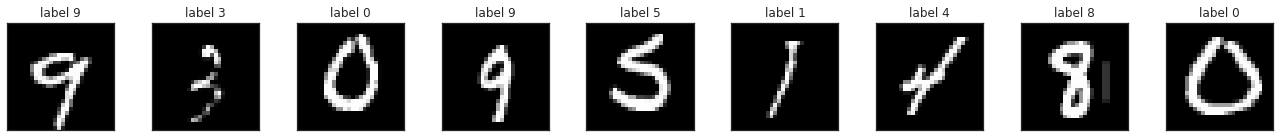

In [4]:
batch_idx, (example_data, example_targets) = next(enumerate(test_loader))

fig = plt.figure(figsize=(18, 4))
for i in range(9):
    ax = plt.subplot(1,9,i+1)
    ax.set_title(f"label {example_targets[i]}")
    plt.tight_layout()
    plt.imshow(example_data[i][0], cmap='gray', interpolation='none')
    plt.xticks([])
    plt.yticks([])

In [5]:
def get_accuracy(model, data_loader, device):
    '''
    Function for computing the accuracy of the predictions over the entire data_loader
    '''  
    model.eval()
    correct_pred = 0 
    n = 0
    
    with torch.no_grad():
        for X, y_true in data_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            _, y_prob = model(X)
            _, predicted_labels = torch.max(y_prob, 1)

            n += y_true.size(0)
            correct_pred += (predicted_labels == y_true).sum()

    acc = correct_pred.float() / n
    
    return acc.item()

def plot_losses(train_losses, valid_losses, title_prefix):
    '''
    Function for plotting training and validation losses
    '''
    plt.figure(figsize=(6, 4),dpi=100)
    train_losses = np.array(train_losses) 
    valid_losses = np.array(valid_losses)
    
    plt.plot(train_losses, color='blue', label='Training loss') 
    plt.plot(valid_losses, color='red', label='Validation loss')
    plt.title(f"{title_prefix}: Loss over epochs") 
    plt.xlabel('Epoch')
    plt.ylabel('Loss') 
    plt.legend()
    
    plt.show()

def train(train_loader, model, criterion, optimizer, device, teacher_model=None):
    '''
    Function for the training step of the training loop
    '''
    model.train()
    running_loss = 0
    
    for X, y_true in train_loader:

        optimizer.zero_grad()
        
        X = X.to(device)
        y_true = y_true.to(device)
    
        # Forward pass
        y_hat, _ = model(X) 
        if not teacher_model:
            loss = criterion(y_hat, y_true)
        else:
            with torch.no_grad():
                y_teacher = teacher_model(X)
            loss = criterion(y_hat, y_true, y_teacher)
            
        running_loss += loss.item() * X.size(0)

        # Backward pass
        loss.backward()
        optimizer.step()
        
    epoch_loss = running_loss / len(train_loader.dataset)
    return model, optimizer, epoch_loss

def validate(valid_loader, model, criterion, device):
    '''
    Function for the validation step of the training loop
    '''
    model.eval()
    running_loss = 0
    
    with torch.no_grad():
        for X, y_true in valid_loader:

            X = X.to(device)
            y_true = y_true.to(device)

            # Forward pass and record loss
            y_hat, _ = model(X) 
            loss = criterion(y_hat, y_true) 
            running_loss += loss.item() * X.size(0)

    epoch_loss = running_loss / len(valid_loader.dataset)
   
    return model, epoch_loss


def training_loop(model, train_criterion, valid_criterion, optimizer, train_loader, valid_loader, 
                  epochs, device, params, print_every=1, teacher_model=None):
    '''
    Function defining the entire training loop
    '''
    # set objects for storing metrics
    best_loss = 1e10
    train_losses = []
    valid_losses = []
    acc_epochs = []
    train_accus = []
    valid_accus = []
    

    # Train model
    for epoch in range(0, epochs):

        # training
        model, optimizer, train_loss = train(train_loader, model, train_criterion, optimizer, device, teacher_model)
        train_losses.append(train_loss)

        # validation
        model, valid_loss = validate(valid_loader, model, valid_criterion, device)
        valid_losses.append(valid_loss)

        if epoch % print_every == (print_every - 1):
            acc_epochs.append(epoch)
            train_acc = get_accuracy(model, train_loader, device=device)
            train_accus.append(train_acc)
            valid_acc = get_accuracy(model, valid_loader, device=device)
            valid_accus.append(valid_acc)
                
            print(f'{datetime.now().time().replace(microsecond=0)} --- '
                  f'Epoch: {epoch}\t'
                  f'Train loss: {train_loss:.4f}\t'
                  f'Valid loss: {valid_loss:.4f}\t'
                  f'Train accuracy: {100 * train_acc:.2f}\t'
                  f'Valid accuracy: {100 * valid_acc:.2f}')

    # save metrics
    plot_losses(train_losses, valid_losses, params['title'])
    res_acc = pd.DataFrame({
        "acc_epoch": acc_epochs,
        "train_accus": train_accus,
        "valid_accus": valid_accus
    })
    res_loss = pd.DataFrame({
        "loss_epoch": range(0, epochs),
        "train_losses": train_losses,
        "valid_losses": valid_losses,
    })
    str_time = datetime.now().strftime("%m-%d_%H-%M")
    res_acc.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_accus.csv", index=False)
    res_loss.to_csv(f"{params['dir']}/{params['prefix']}_{str_time}_losses.csv", index=False)
    
    return model, optimizer, (train_losses, valid_losses)

## LetNet : *Teacher Model*

=======> Teacher model trained with Temperature 20, Dropout 0.5
07:02:30 --- Epoch: 0	Train loss: 0.8641	Valid loss: 0.1988	Train accuracy: 90.65	Valid accuracy: 94.21
07:02:48 --- Epoch: 1	Train loss: 0.3073	Valid loss: 0.1188	Train accuracy: 94.67	Valid accuracy: 96.65
07:03:05 --- Epoch: 2	Train loss: 0.2310	Valid loss: 0.0930	Train accuracy: 95.68	Valid accuracy: 97.12
07:03:22 --- Epoch: 3	Train loss: 0.1905	Valid loss: 0.0765	Train accuracy: 96.33	Valid accuracy: 97.37
07:03:40 --- Epoch: 4	Train loss: 0.1689	Valid loss: 0.0681	Train accuracy: 96.84	Valid accuracy: 97.86
07:03:57 --- Epoch: 5	Train loss: 0.1557	Valid loss: 0.0697	Train accuracy: 97.04	Valid accuracy: 97.84
07:04:14 --- Epoch: 6	Train loss: 0.1438	Valid loss: 0.0579	Train accuracy: 97.32	Valid accuracy: 98.11
07:04:32 --- Epoch: 7	Train loss: 0.1360	Valid loss: 0.0573	Train accuracy: 97.33	Valid accuracy: 98.26
07:04:49 --- Epoch: 8	Train loss: 0.1260	Valid loss: 0.0561	Train accuracy: 97.52	Valid accuracy: 98.16


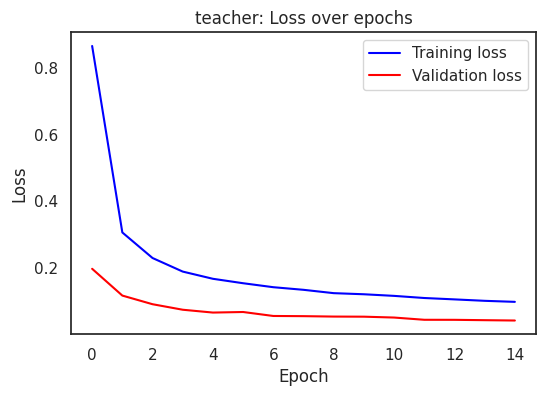

In [12]:
class LargeNet(nn.Module):

    def __init__(self, n_classes, dropout_ratio=0.5, temperature=1):
        super(LargeNet, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Linear(28*28, 1200),
            nn.ReLU(),
            nn.Dropout(p=dropout_ratio),
            nn.Linear(1200, 1200),
            nn.ReLU(),
            nn.Dropout(p=dropout_ratio),
            nn.Linear(1200, 10)
        )
        self.T = temperature

    def forward(self, x):
        x = x.view(-1, 28*28)
        logits = self.model(x)
        probs = F.softmax(logits/self.T, dim=1)
        return logits, probs


# Train
print(f"=======> Teacher model trained with Temperature {TEMP}, Dropout {DROPOUT}")
LEARNING_RATE = 0.01
N_EPOCHS = 15

model_teacher = LargeNet(N_CLASSES, DROPOUT, TEMP).to(DEVICE)
optimizer = torch.optim.SGD(model_teacher.parameters(), lr=LEARNING_RATE, momentum=0.9)
train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()
params = {"dir":'.',
          "prefix": "teacher",
          "title": "teacher"
         }

model_teacher, optimizer, _ = training_loop(model_teacher, train_criterion, valid_criterion, optimizer, 
                                            train_loader, test_loader, N_EPOCHS, DEVICE, params)

# Save model 
torch.save(model_teacher.state_dict(), TEACHER_CHECKPOINT) 

=======> Teacher model
07:13:59 --- Epoch: 0	Train loss: 0.7584	Valid loss: 0.1986	Train accuracy: 90.87	Valid accuracy: 94.69
07:14:16 --- Epoch: 1	Train loss: 0.2227	Valid loss: 0.1133	Train accuracy: 94.74	Valid accuracy: 96.64
07:14:34 --- Epoch: 2	Train loss: 0.1582	Valid loss: 0.0844	Train accuracy: 96.15	Valid accuracy: 97.36
07:14:51 --- Epoch: 3	Train loss: 0.1296	Valid loss: 0.0794	Train accuracy: 96.59	Valid accuracy: 97.57
07:15:08 --- Epoch: 4	Train loss: 0.1101	Valid loss: 0.0674	Train accuracy: 97.15	Valid accuracy: 97.84
07:15:25 --- Epoch: 5	Train loss: 0.0984	Valid loss: 0.0589	Train accuracy: 97.39	Valid accuracy: 98.08
07:15:43 --- Epoch: 6	Train loss: 0.0887	Valid loss: 0.0595	Train accuracy: 97.48	Valid accuracy: 98.09
07:16:00 --- Epoch: 7	Train loss: 0.0814	Valid loss: 0.0618	Train accuracy: 97.48	Valid accuracy: 98.02
07:16:17 --- Epoch: 8	Train loss: 0.0757	Valid loss: 0.0561	Train accuracy: 97.67	Valid accuracy: 98.30
07:16:35 --- Epoch: 9	Train loss: 0.0692	

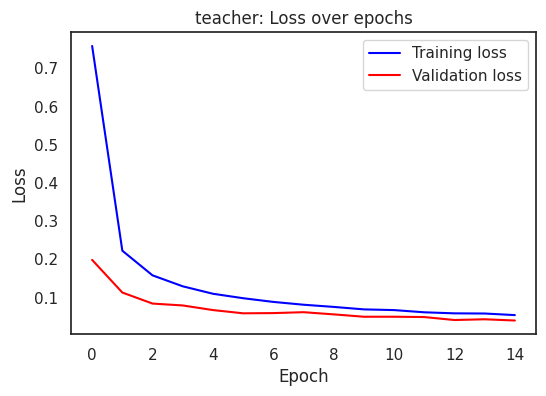

In [15]:
# Train
print(f"=======> Teacher model")
LEARNING_RATE = 0.01
N_EPOCHS = 15

model_teacher = LargeNet(N_CLASSES,0).to(DEVICE)
optimizer = torch.optim.SGD(model_teacher.parameters(), lr=LEARNING_RATE, momentum=0.9)
train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()
params = {"dir":'.',
          "prefix": "teacher",
          "title": "teacher"
         }

model_teacher, optimizer, _ = training_loop(model_teacher, train_criterion, valid_criterion, optimizer, 
                                            train_loader, test_loader, N_EPOCHS, DEVICE, params)

# Save model 
torch.save(model_teacher.state_dict(), TEACHER_CHECKPOINT) 

## Small Model : *Student Model*

=======> Student model
07:06:51 --- Epoch: 0	Train loss: 0.7830	Valid loss: 0.1952	Train accuracy: 90.55	Valid accuracy: 94.20
07:07:08 --- Epoch: 1	Train loss: 0.2339	Valid loss: 0.1132	Train accuracy: 94.89	Valid accuracy: 96.64
07:07:25 --- Epoch: 2	Train loss: 0.1654	Valid loss: 0.1158	Train accuracy: 95.11	Valid accuracy: 96.32
07:07:42 --- Epoch: 3	Train loss: 0.1327	Valid loss: 0.0863	Train accuracy: 96.45	Valid accuracy: 97.38
07:07:59 --- Epoch: 4	Train loss: 0.1157	Valid loss: 0.0718	Train accuracy: 97.04	Valid accuracy: 97.88
07:08:17 --- Epoch: 5	Train loss: 0.1022	Valid loss: 0.0612	Train accuracy: 97.35	Valid accuracy: 97.98
07:08:34 --- Epoch: 6	Train loss: 0.0922	Valid loss: 0.0558	Train accuracy: 97.66	Valid accuracy: 98.19
07:08:51 --- Epoch: 7	Train loss: 0.0859	Valid loss: 0.0590	Train accuracy: 97.65	Valid accuracy: 98.09
07:09:08 --- Epoch: 8	Train loss: 0.0770	Valid loss: 0.0527	Train accuracy: 97.62	Valid accuracy: 98.29
07:09:25 --- Epoch: 9	Train loss: 0.0750	

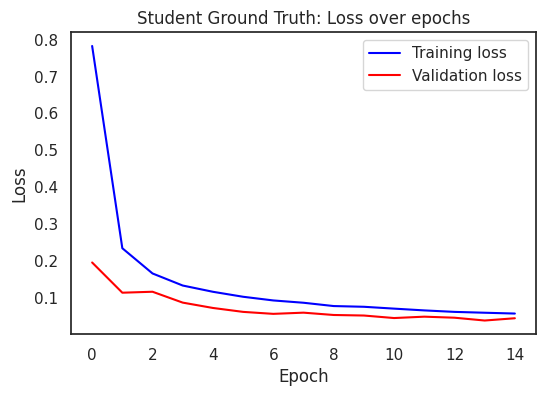

In [13]:
class SmallNet(nn.Module):

    def __init__(self, n_classes, temperature=1):
        super(SmallNet, self).__init__()
        
        self.model = nn.Sequential(            
            nn.Linear(28*28, 800),
            nn.ReLU(),
            nn.Linear(800, 800),
            nn.ReLU(),
            nn.Linear(800, 10)
        )
        self.T = temperature
 
    def forward(self, x):
        x = x.view(-1, 28*28)
        logits = self.model(x)
        probs = F.softmax(logits/self.T, dim=1)
        return logits, probs


# Train
LEARNING_RATE = 0.01
N_EPOCHS = 15

print(f"=======> Student model")
model_s = SmallNet(N_CLASSES).to(DEVICE)
optimizer = torch.optim.SGD(model_s.parameters(), lr=LEARNING_RATE, momentum=0.9)

train_criterion = nn.CrossEntropyLoss()
valid_criterion = nn.CrossEntropyLoss()


dir_path = "./student_models/student_ground_truth"
params = {"dir": dir_path,
          "prefix": "student", 
          "title": "Student Ground Truth"
         }

if not os.path.exists(dir_path):
    os.makedirs(dir_path, exist_ok=True)

model_s, optimizer, _ = training_loop(model_s, train_criterion, valid_criterion, optimizer, train_loader, test_loader,
                                    N_EPOCHS, DEVICE, params)
torch.save(model_s.state_dict(), f"{dir_path}/student_ground_truth_parameters.pt")

## Compare FLOP

In [8]:
!pip install thop
!pip install torchsummary

In [9]:
from thop import profile
from torchsummary import summary

print("teacher model summary:")
teacher_model = LargeNet(N_CLASSES).to(DEVICE)
summary(teacher_model, (1, 28, 28))
flops, params = profile(teacher_model, inputs=torch.rand(1,1,28,28).to(DEVICE))
print(f"FLOPS: {flops}, Params: {params}")

print("\nstudent model summary:")
student_model = SmallNet(N_CLASSES).to(DEVICE)
summary(student_model, (1, 28, 28))
flops, params = profile(student_model, inputs=torch.rand(1,1,28,28).to(DEVICE))
print(f"FLOPS: {flops}, Params: {params}")

teacher model summary:
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                 [-1, 1200]         942,000
              ReLU-2                 [-1, 1200]               0
           Dropout-3                 [-1, 1200]               0
            Linear-4                 [-1, 1200]       1,441,200
              ReLU-5                 [-1, 1200]               0
           Dropout-6                 [-1, 1200]               0
            Linear-7                   [-1, 10]          12,010
Total params: 2,395,210
Trainable params: 2,395,210
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.06
Params size (MB): 9.14
Estimated Total Size (MB): 9.19
----------------------------------------------------------------
[INFO] Register count_linear() for <class 'torch.nn.modules.linear.Linear'>.
[I